Design of a **Coupled Resonator Optical Waveguide** (CROW) band-pass filter with photontorch

## Imports

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm # [pip install tqdm]
import torch # [conda install pytorch -c pytorch, only python 3!]
import photontorch as pt # [pip install photontorch] my simulation/optimization library

## Coupled Resonator Optical Waveguide

A coupled resonator optical waveguide is a cascade of ring resonators.
Such a network with $n$ rings has $2n+1$ parameters that you can optimize: $n$ ring phases and $n+1$ couplings.

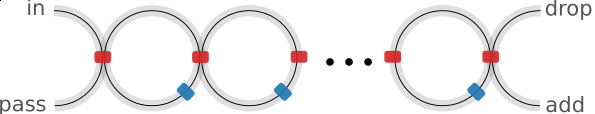

## Parameters

Let's define some global simulation parameters:

In [ ]:
c = 299792458.0 # speed of light
ring_length = 50e-6 #[m]
ng=3.4 # group index
neff=2.34 # effective index

## Simulation Environment

Photontorch expects a simulation environment to be set. This environment contains all global parameters for a simulation, such as the timestep of the simulation, the speed of light for the simulation, the wavelength, ...

In [ ]:
# define the simulation environment:
env = pt.Environment(
    wavelength = 1e-6*np.linspace(1.50, 1.6, 1001), #[m]
    freqdomain=True, # we will be doing frequency domain simulations
)

# set the global simulation environment:
pt.set_environment(env)

# one can always get the current environment from photontorch:
print(pt.current_environment())

## Components

The network defined above consists of directional couplers and waveguides. We could use the `photontorch` default components (`pt.Waveguide` and `pt.DirectionalCoupler`), but as a good introduction to photontorch, we will define them ourselves.

## Waveguide

A waveguide is a component with two ports. The waveguide introduces a delay (for time domain simulations; we will not use this here) and a phase shift. An additional `torch` optimizeable parameter is added to the waveguide, which acts as an additional phase shift on top of the phase introduced by the ring length. You can think of this as for example a heater on top of the waveguide which adjusts the phase of the ring.

In [ ]:
class Waveguide(pt.Component):
    """ Waveguide
    
    Each waveguides has two ports. They are numbered 0 and 1:
    
    Ports:

        0 ---- 1

    """
    
    # photontorch requires you to explicitly define the number of 
    # ports in the component as a class variable:
    num_ports = 2

    def __init__(
        self,
        length=1e-5,
        loss=0, # in dB/m
        neff=2.34, # effective index of the waveguide
        ng=3.40, # group index of the waveguide
        wl0=1.55e-6, # center wavelength for which the waveguide is defined
        phase=0, # additional phase PARAMETER added to the waveguide
        trainable=True, # a flag to make the the component trainable or not
        name=None, # name of the waveguide
    ):
        """ creation of a new waveguide """
        super(Waveguide, self).__init__(name=name)# always initialize parent first
        # Handle inputs
        self.loss = float(loss)
        self.neff = float(neff)
        self.wl0 = float(wl0)
        self.ng = float(ng)
        self.length = float(length)
        
        
        # handle phase input
        phase = float(phase) % (2*np.pi)
        if not trainable: # if the network is not trainable, just store it as a normal float:
            self.phase = phase
        else: # else, make an optimizable parameter out of it:
            # create a torch tensor from the phase
            phase = torch.tensor(phase, dtype=torch.float64)
            # store the phase as a optimizable parameter
            self.phase = torch.nn.Parameter(data=phase)

    def set_delays(self, delays):
        """ set the delays for time-domain simulations """
        delays[:] = self.ng * self.length / self.env.c

    def set_S(self, S):
        """ set the S-matrix
        
        NOTE: because PyTorch does not support complex tensors, the real 
        ane imaginary part of the S-matrix are stored in an extra dimension
        
        NOTE2: the S-matrix needs to be defined for all wavelengths, therefore
        one needs an extra dimension to store each different S-matrix for each 
        wavelength
        
        ----------------
        
        Taking the above two notes into account, the S-matrix is thus a
        4-D tensor with shape
        
        (2=(real|imag), #wavelengths, #ports, #ports)
        
        """
        # during a photontorch simulation, the simulation environment
        # containing all the global simulation parameters will be 
        # available to you as `self.env`:
        current_simulation_environment = self.env
        
        # you can use this environment to get information about the
        # wavelengths used in the simulation:
        wavelength = current_simulation_environment.wavelength
        
        # however, this wavelength is stored as a numpy array, while
        # photontorch expect torch tensors. We need to make a torch
        # tensor out of this:
        wavelength = torch.tensor(
            wavelength, # make this numpy array into a torch tensor
            dtype=torch.float64, # keep float64 dtype
            device=self.device, # put it on the current device ('cpu' or 'gpu')
        )
        
        # next we implement the dispersion, which will depend on the
        # wavelength tensor
        neff = self.neff - (wavelength - self.wl0) * (self.ng - self.neff) / self.wl0
        
        # we have now calculated an neff for each different wavelength.
        # let's calculate the phase depending on this neff:
        phase = (2 * np.pi * neff * self.length / wavelength) % (2 * np.pi)
        
        # next, we add the phase correction parameter.
        phase = phase + self.phase
        # note that in pytorch, inplace operations, such as
        # phase += self.phase
        # are not allowed, as they obscure the computation graph necessary to 
        # perform the backpropagation algorithm later on...
        
        # because pytorch does not allow complex numbers, we split up exp(1j*phase) into
        # its real and imaginary part and revert back to the default dtype (usually float32).
        cos_phase = torch.cos(phase).to(torch.get_default_dtype())
        sin_phase = torch.sin(phase).to(torch.get_default_dtype())

        # finally, we can calculate the loss and add it to the phase, which
        # gives us the S-matrix parameters
        loss = 10 ** (-self.loss * self.length / 20)  # 20 because loss works on power
        re = loss * cos_phase
        ie = loss * sin_phase

        # the last thing to do is to add the S-matrix parameters to the S-matrix:
        S[0, :, 0, 1] = S[0, :, 1, 0] = re
        S[1, :, 0, 1] = S[1, :, 1, 0] = ie

## Directional Coupler

The second component we need is a directional coupler. A directional coupler has a single optimizeable parameter: its **coupling**. It introduces no delays.

In [ ]:
class DirectionalCoupler(pt.Component):
    r""" A directional coupler is a component with 4 ports that introduces no delays
    
    Each directional coupler has four ports. They are numbered 0 to 3:

    Ports:
       3        2
        \______/
        /------\
       0        1

    """

    # photontorch requires you to explicitly define the number of 
    # ports in the component as a class variable:
    num_ports = 4

    def __init__(self, coupling=0.5, name=None):
        """ creation of a new waveguide """
        super(DirectionalCoupler, self).__init__(name=name)# always initialize parent first
        
        # to save the coupling as an optimizable parameter, we could just do the
        # same as we did for the waveguide: create a torch tensor and store it as a parameter:
        # coupling = torch.tensor(float(coupling))
        # self.phase = torch.nn.Parameter(data=coupling)
        
        # however, this could lead to problems, as this parameter would be unbounded
        # and we know for a fact the coupling should be bounded between 0 and 1.
        # an easy solution is to define the coupling as the cosine of a hidden parameter
        # which we call (with little imagination) `parameter`:
        
        # create a parameter. The coupling will be derived from the parameter as cos(self.parameter):
        parameter = torch.tensor(np.arccos(float(coupling)), dtype=torch.get_default_dtype())
        self.parameter = torch.nn.Parameter(data=parameter)
    
    @property
    def coupling(self):
        return torch.cos(self.parameter)

    def set_S(self, S):
        """ Fill the S-matrix with elements. Rememeber that the S-matrix has a shape
        
        (2=(real|imag), #wavelengths, #ports, #ports)
        
        """
        
        t = (1 - self.coupling) ** 0.5
        k = self.coupling ** 0.5

        # real part scattering matrix (transmission):
        S[0, :, 0, 1] = S[0, :, 1, 0] = t # same for all wavelengths
        S[0, :, 2, 3] = S[0, :, 3, 2] = t # same for all wavelengths

        # imag part scattering matrix (coupling):
        S[1, :, 0, 2] = S[1, :, 2, 0] = k # same for all wavelengths
        S[1, :, 1, 3] = S[1, :, 3, 1] = k # same for all wavelengths

## A first filter: the AllPass

As a first "filter" we define a simple AllPass filter, which we define as a photontorch `Network` of a `Waveguide` and a `DirectionalCoupler`.

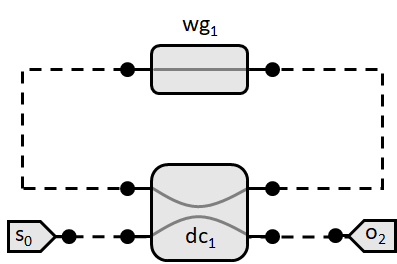

## Network Definition

In [ ]:
class AllPass(pt.Network):
    def __init__(
        self,
        ring_length=1e-5, #[um] length of the ring
        ring_loss=1, #[dB]: roundtrip loss in the ring
        name=None
    ):
        super(AllPass, self).__init__(name=name) # always initialize parent first
        
        # handle arguments:
        self.ring_length = float(ring_length)
        self.ring_loss = float(ring_loss),
        
        # define subcomponents
        self.source = pt.Source()
        self.detector = pt.Detector()
        self.dc = DirectionalCoupler()
        self.wg = Waveguide(length=ring_length, loss=ring_loss/ring_length)

        # link subcomponents together:

        # The `link` method takes an arbitrary number of string arguments. 
        # Each argument contains the component name together with a port numbe
        # in front of and a port number behind the name (e.g. `"0:wg:1"`).
        # The port number behind the name will connect to the port number 
        # in front of the next name. The first component does not need 
        # a port number in front of it, while the last component does 
        # not need a port number behind.

        self.link('source:0', '0:dc:2', '0:wg:1', '3:dc:1', '0:detector')

## Simulation

First, we have to create an instance of our network

In [ ]:
allpass = AllPass()

We can simulate the AllPass filter by just using it as a normal function on a source array. What you will get out is the detected array. If you are just simulating a constant source (which obviously is the case in the frequency domain), one can just add a source amplitude:

In [ ]:
detected = allpass(source=1)
print(detected.shape)

We see that we get a 4D array out. This is always the case. Photontorch always returns 4D arrays. The shape of the array corresponds to
```
    (# timesteps, # wavelengths, # detectors, # parallel simulations)
```
In this case, we only simulated for a single timestep, as we are doing a frequency domain simulation. Moreover, we simulated for 1001 wavelengths and we had a single detector in the network. The number of parallel simulations can be useful for training purposes, as we will see later.

Each network also has a plotting function that smartly handles the 4D detected array and gives you the most useful plot possible:

In [ ]:
allpass.plot(detected)
plt.show()

## Optimization

This is neat, but what if we want to filter out the wavelength at 1550nm: We can shift the transmission minimum to 1550nm as follows:

First we define a target function for the transmission at 1550nm. We want it to be as close as possible to 0, so let's just take 0:

In [ ]:
target = torch.tensor(0.0)

Next, we choose a loss to be optimized. Let's take the [MSE loss](https://en.wikipedia.org/wiki/Mean_squared_error):

In [ ]:
lossfunc = torch.nn.MSELoss()

Finally, we need to choose an optimizer to find the minimum in the loss for us. PyTorch has a [whole collection](https://pytorch.org/docs/stable/optim.html) of optimizers readily available. They are all based on a version of gradient descent. However, if you do not know which one to use, the `Adam` optimizer is always a good choice:

In [ ]:
# to define an optimizer, one needs to provide the parameters to optimize
# and the learning rate of the optimizer. 
# the learning rate is an important parameter that needs to be tuned manually to 
# the right value. A too large learning rate will result in an optimizer that cannot find the loss
# a too small value may result in a very long optimization time:
optimizer = torch.optim.Adam([allpass.wg.phase], lr=0.03) # let's just optimize the phase of the ring

Furthermore, for this optimization, we will just simulate at a single wavelength: 1550nm. We can define a new environment. Also, we will use this environment for training purposes so **one needs to allow gradient tracking**:

In [ ]:
train_env = pt.Environment(
    wavelength = 1.55e-6, #[m]
    freqdomain=True, # we will be doing frequency domain simulations
    grad=True, # allow gradient tracking
)

Note that this environment is not yet enabled. One can do this globally with the `pt.set_environment` function. However, we will choose to only *temporarily* use this environment by using a **context-manager** or **with-block**:

In [ ]:
with train_env: # temporarily override the global environment
    # we train for 400 training steps
    for i in tqdm(range(400)):
        optimizer.zero_grad() # set all the gradients to zero
        result = torch.squeeze(allpass(source=1)) # squeeze: 4D -> 0D
        loss = lossfunc(result, target) # MSE loss
        loss.backward() # calculate the gradients
        optimizer.step() # use the calculated gradients to perform an optimization step

print("loss: %.5f"%loss.item())

Now that the allpass filter is trained to have minimal transmission at 1550 nm, Let's have a look by simulating it again:

In [ ]:
detected = allpass(source=1)
allpass.plot(detected)
plt.plot([1550,1550],[0,1])
plt.ylim(0,1)
plt.show()

We clearly found a minimum at 1550 nm. 

However, we can do better! What if we decide to also optimize the coupling of the directional coupler? Let's have a look:

In [ ]:
# let's just optimize both the phase and the coupling
optimizer = torch.optim.Adam([allpass.wg.phase, allpass.dc.parameter], lr=0.03)

**Sidenote**: in stead of explicitly listing all the parameters in the optimization, one can also use the `.parameters()` method, to get all optimizable parameters of the network. For the creation of the optimizer above, this would be:
```python
optimizer = torch.optim.Adam(allpass.parameters(), lr=0.03)
```

In [ ]:
with train_env: # temporarily override the global environment
    # we train for 400 training steps
    for i in tqdm(range(400)):
        optimizer.zero_grad() # set all the gradients to zero
        result = torch.squeeze(allpass(source=1)) # squeeze: 4D -> 0D
        loss = lossfunc(result, target) # MSE loss
        loss.backward() # calculate the gradients
        optimizer.step() # use the calculated gradients to perform an optimization step

print("loss: %.5f"%loss.item())

By optimizing both the phase in the ring and the coupling to the ring, we can get 0 loss!

In [ ]:
detected = allpass(source=1)
allpass.plot(detected)
plt.plot([1550,1550],[0,1])
plt.ylim(0,1)
plt.show()

## Extra: Time domain simulation

As an aside, one can also do time domain simulations. Let's do a time domain simulation of the optimized ring at 3 different wavelengths simultaneously:

In [ ]:
# define the simulation environment:
time_domain_env = pt.Environment(
    time = np.linspace(0, 1e-11, 1000),
    wavelength = [1.547e-6, 1.550e-6, 1.560e-6], #[m]
    freqdomain=False, # we will be doing a time domain simulation
)

In [ ]:
with time_domain_env:
    detected = allpass(source=1)
    allpass.plot(detected)

## Coupled Resonator Optical Waveguide

After this introduction, we can go on to define a real filter: a CROW:

In [ ]:
class Crow(pt.Network):
    def __init__(
        self,
        num_rings=1,
        ring_length=1e-5, #[m]
        loss=1000, #[dB/m]
        neff=2.34,
        ng=3.4,
        wl0=1.55e-6,
        random_parameters=False,
        name=None
    ):
        super(Crow, self).__init__(name=name) # always initialize parent first
        
        # handle variables
        self.num_rings = int(num_rings)
        
        # define source and detectors:
        self.source = pt.Source()
        self.pass_ = pt.Detector()
        self.drop = pt.Detector()
        self.add = pt.Detector()
        
        # if the random_parameters flag is set, we will initialize with 
        # random parameters, else, we will initialize with parameters
        # set to zero:
        random_coupling = np.random.rand if random_parameters else (lambda : 0.5)
        random_phase = (lambda : 2*np.pi*np.random.rand()) if random_parameters else (lambda :0)
        
        # define directional couplers
        for i in range(self.num_rings + 1):
            self.add_component(
                name="dc%i"%i,
                comp=DirectionalCoupler(
                    coupling=random_coupling(), # initialize with random coupling
                )
            )
        
        # define waveguides between directional couplers:
        # let's only make the bottom waveguide trainable.
        for i in range(self.num_rings):
            self.add_component(
                name="top_wg%i"%i,
                comp=Waveguide(
                    length=0.5*ring_length,
                    loss=loss,
                    neff=neff,
                    ng=ng,
                    wl0=wl0,
                    phase=0,
                    trainable=False,
                )
            )
            self.add_component(
                name="btm_wg%i"%i,
                comp=Waveguide(
                    length=0.5*ring_length,
                    loss=loss,
                    neff=neff,
                    ng=ng,
                    wl0=wl0,
                    phase=random_phase(), # initialize with random phase
                    trainable=True,
                )
            )
        
        # lets now define the links
        link1 = ["source:0"]
        link2 = ["pass_:0"]
        for i in range(self.num_rings):
            link1 += ["0:dc%i:3"%i, "0:top_wg%i:1"%i]
            link2 += ["1:dc%i:2"%i, "0:btm_wg%i:1"%i]
        
        if self.num_rings % 2 == 1: # top=drop, btm=add
            link1 += ["0:dc%i:3"%(self.num_rings), "0:drop"]
            link2 += ["1:dc%i:2"%(self.num_rings), "0:add"]
        else: # top=add, btm=drop
            link1 += ["0:dc%i:3"%(self.num_rings), "0:add"]
            link2 += ["1:dc%i:2"%(self.num_rings), "0:drop"]
            
        self.link(*link1)
        self.link(*link2)

## Single ring CROW:

In [ ]:
crow = Crow(num_rings=1)
detected = crow(source=1)
crow.plot(detected)
plt.show()

## Multiple ring CROW:

In [ ]:
from ipywidgets import interact, IntSlider
@interact(num_rings=IntSlider(min=1, max=10, step=1))
def plot_detected(num_rings=5):
    crow = Crow(num_rings=num_rings)
    detected = crow(source=1)
    crow.plot(detected)
    plt.show()

## Optimizing a CROW
We will optimize a crow with 10 rings and randomly initialized parameters

In [ ]:
device = 'cuda' # 'cpu' or 'cuda'
crow = crow = Crow(num_rings=10, random_parameters=False).to(device)

We will also do a simulation on a smaller range than the globally set environment:

In [ ]:
train_env = pt.Environment(
    wavelength = 1e-6*np.linspace(1.53, 1.58, 1001), #[m]
    freqdomain=True, # we will be doing frequency domain simulations
    grad=True, # we need to enable gradients to be able to optimize
)

lets have a look at an initial simulation:

In [ ]:
# over the original domain
detected = crow(source=1)[0,:,-1,0] # single timestep, all wls, drop detector, single batch
crow.plot(detected)
plt.show()

# over the trainin domain:
with train_env:
    detected = crow(source=1)[0,:,-1,0] # single timestep, all wls, drop detector, single batch
    crow.plot(detected)
    plt.show()

Let's now define a target that is one over a range of 10 nm and zero over the rest:

In [ ]:
target = np.zeros_like(train_env.wavelength)
target[train_env.wavelength > 1.55e-6] = 1
target[train_env.wavelength > 1.56e-6] = 0
target = torch.tensor(target, dtype=torch.get_default_dtype(), device=device)
crow.plot(target)
plt.show()

Finally, we need to define an optimizer that optimizes all parameters of the network:

In [ ]:
optimizer = torch.optim.Adam(crow.parameters(), lr=0.01)

We can now start the training

In [ ]:
range_ = tqdm(range(150)) # we train for 150 training steps
with train_env: # temporarily override the global environment
    for i in range_:
        crow.initialize()
        optimizer.zero_grad() # set all the gradients to zero
        
        # take result for single timestep, all wavelengths, pass
        result = crow(source=1)[0,:,-1,0] # single timestep, all wls, drop detector, single batch
        loss = lossfunc(result, target) # MSE loss
        loss.backward() # calculate the gradients
        optimizer.step() # use the calculated gradients to perform an optimization step
        range_.set_postfix(loss=loss.item())

print("loss: %.5f"%loss.item())

In [ ]:
# over the training domain:
with train_env:
    detected = crow(source=1)
    crow.plot(target, label="target")
    crow.plot(detected)
    plt.show()